# Task 1: Single Object Tracking
## Improved Method: Kalman Filter

### import libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cv2

### load images sequence

In [10]:
def load_sequence(seq_path):
    """
    Load image sequence using OpenCV
    
    Params:
        seq_path: Path to the folder containing the image sequence
    Returns:
        images: List containing all loaded images
    """
    images = []
    # get all jpg files    
    img_files = sorted(Path(seq_path).glob('img/*.jpg')) 
    for img_file in img_files:
        img = cv2.imread(str(img_file))
        images.append(img)
    print(f"loaded {len(images)} images from {seq_path}")
    
    return images

### get the template from firsttrack.txt

In [7]:
def get_first_template(seq_path, first_frame):
    """
    Extract template from first frame using bounding box coordinates
    
    Parameters:
        seq_path: Path to the image sequence directory
    Returns:
        template: Template image (cropped region)
        img: First frame image with original dimensions
    """
    with open(os.path.join(seq_path, 'firsttrack.txt'), 'r') as f:
        first_box = [int(x) for x in f.read().strip().split(',')]
    x, y, w, h = map(int, first_box)
    template_box = [x,y,w,h]
    template = first_frame[y:y+h, x:x+w]
    return template,template_box


### template matching

In [8]:
def template_matching(template, template_box, img, search_area=500):
    """
    Template matching with search area limitation
    
    Parameters:
        template: Template image from previous frame
        template_box: Bounding box coordinates [x, y, width, height]
        img: Current frame image for processing
        search_area: Size of search area around previous position (pixels)
    Returns:
        new_box: Detected bounding box coordinates [x, y, width, height]
        new_template: Updated template image (optional appearance adaptation)
    """
    # limit the search area
    [x,y,w,h] = template_box
    # print(x,y,w,h)
    # h, w = template.shape[:2]
    roi = img[max(0, y-search_area):min(img.shape[0], y+h+search_area),
              max(0, x-search_area):min(img.shape[1], x+w+search_area)]
    
    # use cv2.TM_CCOEFF_NORMED method for template matching
    result = cv2.matchTemplate(roi, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # convert to original image coordinates
    x = max(0, x-search_area) + max_loc[0]
    y = max(0, y-search_area) + max_loc[1]

    new_box=[x,y,w,h]
    
    # update template (optional, prevent target appearance changes)
    # new_template = img[y:y+h, x:x+w]
    new_template = template
    
    # 返回跟踪框 box=[x, y, width, height]
    return new_template, new_box

### kalman filter

In [9]:
def init_kalman_filter(initial_box):
    """初始化卡尔曼滤波器
    Parameters:
        initial_box: 初始目标框 [x,y,w,h]
    Returns:
        kf: 配置好的KalmanFilter对象
    """
    kf = cv2.KalmanFilter(4, 2)  # 4个状态量(x,y,vx,vy)，2个观测量(x,y)
    kf.transitionMatrix = np.array([[1,0,1,0],
                                    [0,1,0,1],
                                    [0,0,1,0],
                                    [0,0,0,1]], np.float32)  # 状态转移矩阵
    kf.measurementMatrix = np.array([[1,0,0,0],
                                     [0,1,0,0]], np.float32)   # 观测矩阵
    kf.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03   # 过程噪声
    kf.measurementNoiseCov = np.eye(2, dtype=np.float32) * 0.1 # 观测噪声
    
    # 初始化状态：使用初始检测框中心作为位置，速度设为0
    initial_center = [initial_box[0]+initial_box[2]/2, 
                     initial_box[1]+initial_box[3]/2]
    kf.statePost = np.array([[initial_center[0]], [initial_center[1]], [0], [0]], dtype=np.float32)
    return kf

In [10]:
def kalman_update(kf, detected_box):
    """卡尔曼滤波更新步骤
    Parameters:
        kf: 卡尔曼滤波器对象
        detected_box: 当前帧检测框 [x,y,w,h]
    Returns:
        corrected_box: 修正后的目标框 [x,y,w,h]
    """
    # 将检测框中心作为观测值
    measurement = np.array([[detected_box[0]+detected_box[2]/2],
                          [detected_box[1]+detected_box[3]/2]], dtype=np.float32)
    
    # 执行卡尔曼修正
    kf.correct(measurement)
    
    # 获取修正后的状态（中心坐标）
    predicted_state = kf.predict()
    corrected_center = (int(predicted_state[0][0]), int(predicted_state[1][0]))
    
    # 保持宽高不变，返回修正后的框
    return [corrected_center[0]-detected_box[2]//2,
           corrected_center[1]-detected_box[3]//2,
           detected_box[2],
           detected_box[3]]

### tracking sequence

In [11]:
def track_sequence_improved(seq_path):
    """
    Perform template matching tracking on image sequence
    
    Parameters:
        template: Template image from previous frame
        template_box: Bounding box coordinates [x, y, width, height]
        img: Current frame image for processing
    Returns:
        tracking_results: List of tracked bounding boxes [[x, y, width, height], ...]
    """
    # 1st step: load sequence
    seq_images = load_sequence(seq_path)
    # 2nd step: get first template
    pre_template, pre_template_box = get_first_template(seq_path, seq_images[0])
    # 3rd step: tracking sequence
    tracking_results = []
    tracking_results.append(pre_template_box)
    # 4th step: init kalman filter
    kf = init_kalman_filter(pre_template_box)

    for img in seq_images[1:]:
        new_template, new_box = template_matching(pre_template, pre_template_box, img)
        
        # 新增卡尔曼滤波修正
        corrected_box = kalman_update(kf, new_box)  # 用检测结果更新卡尔曼
        
        pre_template = new_template
        # pre_template_box = new_box
        pre_template_box = corrected_box
        tracking_results.append(new_box)
    
    return tracking_results

### save tracking results

In [12]:
def save_results(tracking_results, output_path):
    """Save tracking results to specified file in current directory
    
    Parameters:
        tracking_results: List of tracked bounding boxes
        output_path: Output filename (default: trackresults_TM_seq1.txt)
    """
    # Create parent directories if needed
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Write results to current directory
    with open(output_path, 'w') as f:
        for bbox in tracking_results:
            f.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")
    print(f"Results saved to: {os.path.abspath(output_path)}")


### running code to get tracking results of 5 sequences

In [14]:
seq_paths = ["./data/seq1",
             "./data/seq2",
             "./data/seq3",
             "./data/seq4",
             "./data/seq5"]
seq_names = ["seq1", "seq2", "seq3", "seq4", "seq5"]
for i, seq_path in enumerate(seq_paths):
    tracking_results = track_sequence_improved(seq_path)
    save_results(tracking_results, f"./results/improved/trackresults_improved_{seq_names[i]}.txt")


loaded 150 images from ./data/seq1
Results saved to: /Users/mike_wang/SourceCodes/AutoMobileRoboticsHW/E1373807_Homework1/Task1/results/improved/trackresults_improved_seq1.txt
loaded 150 images from ./data/seq2
Results saved to: /Users/mike_wang/SourceCodes/AutoMobileRoboticsHW/E1373807_Homework1/Task1/results/improved/trackresults_improved_seq2.txt
loaded 150 images from ./data/seq3
Results saved to: /Users/mike_wang/SourceCodes/AutoMobileRoboticsHW/E1373807_Homework1/Task1/results/improved/trackresults_improved_seq3.txt
loaded 150 images from ./data/seq4
Results saved to: /Users/mike_wang/SourceCodes/AutoMobileRoboticsHW/E1373807_Homework1/Task1/results/improved/trackresults_improved_seq4.txt
loaded 150 images from ./data/seq5
Results saved to: /Users/mike_wang/SourceCodes/AutoMobileRoboticsHW/E1373807_Homework1/Task1/results/improved/trackresults_improved_seq5.txt


### load the boxes data

In [2]:
def load_boxes_data(file_path):
    """
    load boxes data
    params:
        file_path: data path
    returns:
        boxes: list of all boxes
    """
    boxes = []
    with open(file_path, 'r') as f:
        for line in f:
            box = [float(x) for x in line.strip().split(',')]
            boxes.append(box)
    return boxes

### calculate the metrics

In [3]:
def calculate_metrics(tracking_results, ground_truth_path):
    """
    calculate the Success and Precision of each frame
    Success = Intersection/Union (IoU)
    Precision = Center Distance
    """
    def box2xy(box):
        x,y,w,h = box
        return x,y,x+w,y+h
    
    def box2center(box):
        x,y,w,h = box
        return x+w/2,y+h/2

    def calculate_iou(result_box,ground_truth_box):  
        rb=box2xy(result_box)
        gtb=box2xy(ground_truth_box)

        inter_x1=max(rb[0],gtb[0])
        inter_y1=max(rb[1],gtb[1])
        inter_x2=min(rb[2],gtb[2])
        inter_y2=min(rb[3],gtb[3])

        if inter_x1<inter_x2 and inter_y1<inter_y2:
            inter_area=(inter_x2-inter_x1)*(inter_y2-inter_y1)
        else:
            inter_area=0

        result_area=(rb[2]-rb[0])*(rb[3]-rb[1])
        ground_truth_area=(gtb[2]-gtb[0])*(gtb[3]-gtb[1])

        union_area=result_area+ground_truth_area-inter_area

        return inter_area / union_area if union_area > 0 else 0.0
    
    def calculate_center_distance(result_box,ground_truth_box): 
        rb=box2center(result_box)
        gtb=box2center(ground_truth_box)

        return np.sqrt((rb[0]-gtb[0])**2+(rb[1]-gtb[1])**2)
    
    success=calculate_iou(tracking_results,ground_truth_path)
    precision=calculate_center_distance(tracking_results,ground_truth_path)

    return success,precision        

### calculate the average precision and success of each sequence

In [4]:
def calculate_seq_metrics(seq_results, seq_gt, threshold_p=50,threshold_s=0.5):
    """
    calculate the average precision and success of each sequence
    """
    success = []
    precision = []
    for i in range(len(seq_results)):
        s,p=calculate_metrics(seq_results[i], seq_gt[i])
        if p<threshold_p:
            p=0
        else:
            p=1
        if s>threshold_s:
            s=1
        else:
            s=0
        success.append(s)
        precision.append(p)
    return np.mean(success), np.mean(precision)

### running code to get precision and success of each sequence

In [7]:
seq_results_paths = ["./results/improved/trackresults_improved_seq1.txt",
               "./results/improved/trackresults_improved_seq2.txt",
               "./results/improved/trackresults_improved_seq3.txt",
               "./results/improved/trackresults_improved_seq4.txt",
               "./results/improved/trackresults_improved_seq5.txt"]
threshold_p = [50,40,150,50,50]
for i, seq_result in enumerate(seq_results_paths):
    ground_truth_path = f"./data/seq{i+1}/groundtruth.txt"
    tracking_results = load_boxes_data(seq_result)
    ground_truth = load_boxes_data(ground_truth_path)
    success, precision = calculate_seq_metrics(tracking_results, ground_truth,threshold_p[i])
    print(f"improved method: Sequence{i+1} - Success: {success:.2f}, Precision: {precision:.2f}")


improved method: Sequence1 - Success: 0.33, Precision: 0.37
improved method: Sequence2 - Success: 0.48, Precision: 0.51
improved method: Sequence3 - Success: 0.12, Precision: 0.79
improved method: Sequence4 - Success: 0.31, Precision: 0.65
improved method: Sequence5 - Success: 0.74, Precision: 0.18


### visualization

In [8]:
def visualization(img,result_box,ground_truth_box):
    """
    visualization the result
    """
    r_x,r_y,r_w,r_h = map(int,result_box)
    g_x,g_y,g_w,g_h = map(int,ground_truth_box)
    
    # red: result 
    cv2.rectangle(img, (r_x, r_y), (r_x+r_w, r_y+r_h), (0, 0, 255), 2) 
    # green: ground truth 
    cv2.rectangle(img, (g_x, g_y), (g_x+g_w, g_y+g_h), (0, 255, 0), 2) 
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

### running code to visualize the result

loaded 150 images from ./data/seq1


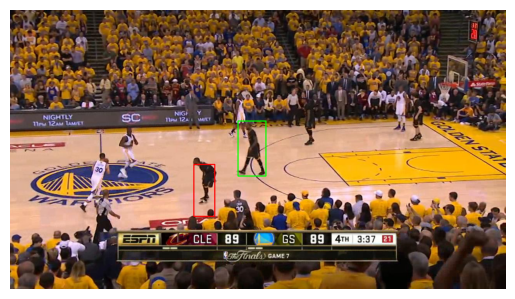

([474.0, 398.0, 54.0, 134.0], [588.0, 286.0, 72.0, 142.0])

In [11]:
seq_path = "./data/seq1"
seq_images = load_sequence(seq_path)
img_index = 50
vis_img = seq_images[img_index]

result_box = load_boxes_data("./results/TM/trackresults_TM_seq1.txt")[img_index]
ground_truth_box = load_boxes_data("./data/seq1/groundtruth.txt")[img_index]
visualization(vis_img,result_box,ground_truth_box)

result_box,ground_truth_box